# A. Importing Library

In [1]:
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D

from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
from matplotlib.pyplot import figure
from sklearn.metrics import accuracy_score, precision_score, recall_score

import joblib
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

# B. Defining functions

In [2]:
# nucleotide to unit vector
def one_hot(base):
  return np.array({'a':[1,0,0,0], 
                   't':[0,1,0,0], 
                   'g':[0,0,1,0], 
                   'c':[0,0,0,1]}[base.lower()])

# replace nucleotide for unit vector using one_hon()
def Hot(seq): 
  seq_one_hot = np.zeros((len(seq)*4, )) # zero 200,1 matrix 
  for i in range(len(seq)): seq_one_hot[4*i : 4*i+4] = one_hot(seq[i])
  return seq_one_hot

# normalize data (-1 to +1)
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# print results function
def print_results(results):
    print('Best Params: {}\n'.format(results.best_params_))
    
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means,stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean,3),round(std*2,3),params))

        
def clean_data(d1):
    # change column name
    d2 = d1.rename(columns={d1.columns[0]:'index',d1.columns[1]:'seq100',d1.columns[2]:'c26',d1.columns[3]:'c29', d1.columns[4]:'c31',d1.columns[5]:'c0'}) 


    # remove overhanger
    seq =[]
    for i in range(len(d2['seq100'])):
        seq.append(d2['seq100'][i][25:75])
    d3 = pd.DataFrame(seq,columns=['seq50'])
    d4 = pd.concat([d2,d3],axis=1)
    df = d4.drop(['index','seq100'],axis=1)

    #take a random sample of 10000
    df = df.sample(n=len(df))
    return  df

def encode_dna_seq(df):
    # extract column of sequence
    SeqList = df['seq50'].tolist()

    # extract c0 values
    dy = np.around(df['c0'].values,3) 

    # encode dna sequence
    d = [] 
    for i in range(len(SeqList)): 
        d.append(Hot(SeqList[i])) 
    d = np.array(d)
    dx = pd.DataFrame(d)
    input = dx.values
    return input,dy

def split_data_tvt(dx,dy):
    x_train, x_test, y_train, y_test  = train_test_split(dx,dy,shuffle=True, test_size=0.40, random_state=1234)
    x_val, x_test, y_val, y_test  = train_test_split(x_test,y_test,shuffle=True, test_size=0.50, random_state=1234)
    return x_train, y_train, x_val, y_val, x_test, y_test

# C. Importing data

In [3]:
d = pd.read_csv('C:/Users/bciez/Documents/Basilio/jhu/ha-lab/dna_flexibility/thesis_01_18_2022/data/dataset3.txt',delimiter='\t')
print('ready')

ready


# D. Cleaning data

In [4]:
df = clean_data(d)
df.head(3)

,c26,c29,c31,c0,Amplitude,Phase,seq50
10795,-0.095716,-0.486001,-0.463561,-0.235199,-0.225695,-0.666217,GCTACGGAAGCCCCGGCCAGTGCGCACCCCGCCGAGTTCCTTACAT...
2270,-0.155811,-0.604154,-0.219390,-0.155084,-0.379438,0.001916,TCTATCACTTAGCGCGGGTGGCTCTGCCCGTCGACAGCAGCTACCT...
515,-1.041432,-1.174699,-0.492700,-0.786706,-0.466202,0.578042,GGGGAACGGTCACGTTCTCTTCATAGTTGAACGGTCAATGTAAAGA...


# E. Encoding DNA sequence

In [5]:
dx,dy = encode_dna_seq(df)
print('ready')

ready


# F. Split data in training and testing set

In [6]:
x_train, y_train, x_val, y_val, x_test, y_test = split_data_tvt(dx,dy)

dim = x_train.shape
x_train = x_train.reshape(dim[0],dim[1],1)

dim = x_test.shape
x_test = x_test.reshape(dim[0],dim[1],1)
print('ready')

ready


# G. Support Vector Machine

In [7]:
model = keras.Sequential([
  keras.layers.Input(shape=(200, 1)), 
  keras.layers.Conv1D(filters=64, kernel_size=20, strides=4, activation=tf.nn.relu), 
  keras.layers.Conv1D(filters=32, kernel_size=33, activation=tf.nn.relu), 
  keras.layers.Flatten(), 
	keras.layers.Dense(50, activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l2(0.001)),
	keras.layers.Dense(1)
	]) # defining model

model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
	loss='mse',
	metrics=['mse']) # compiling model

In [8]:
sample_size = x_train.shape[0] # number of samples in train set
time_steps  = x_train.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
re_input = x_train.reshape(sample_size,time_steps,input_dimension)


#train_images, test_images, train_labels, test_labels = train_test_split(re_input, df['C0'].values, test_size=0.1) # splitting data on trainning and testing

model_history  = model.fit(x_train, y_train,
	epochs=6,
	validation_data=(x_test, y_test),
	verbose=2) # fitting the model

Epoch 1/6
234/234 - 2s - loss: 0.1771 - mse: 0.1473 - val_loss: 0.1332 - val_mse: 0.1246
Epoch 2/6
234/234 - 1s - loss: 0.1346 - mse: 0.1292 - val_loss: 0.1100 - val_mse: 0.1065
Epoch 3/6
234/234 - 1s - loss: 0.0976 - mse: 0.0938 - val_loss: 0.0690 - val_mse: 0.0650
Epoch 4/6
234/234 - 1s - loss: 0.0604 - mse: 0.0565 - val_loss: 0.0564 - val_mse: 0.0528
Epoch 5/6
234/234 - 1s - loss: 0.0505 - mse: 0.0468 - val_loss: 0.0515 - val_mse: 0.0478
Epoch 6/6
234/234 - 1s - loss: 0.0422 - mse: 0.0384 - val_loss: 0.0546 - val_mse: 0.0509


[[1.         0.89481537]
 [0.89481537 1.        ]]


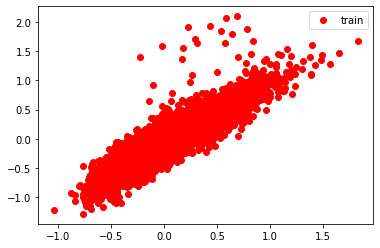

In [9]:
# THIS IS FOR TRAINING DATA ---> IT IS SUPPOSED TO ALWAY DO WELL
LEN = len(x_train)
qwer = model.predict(x_train)
plt.plot(qwer, y_train, 'ro',label='train')
print(np.corrcoef(qwer.reshape((LEN, )), y_train))
plt.legend()

[[1.         0.80654753]
 [0.80654753 1.        ]]


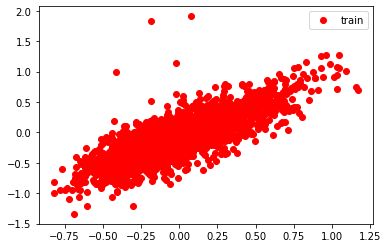

In [10]:
# THIS IS FOR TRAINING DATA ---> IT IS SUPPOSED TO ALWAY DO WELL
LEN = len(x_test)
qwer = model.predict(x_test)
plt.plot(qwer, y_test, 'ro',label='train')
print(np.corrcoef(qwer.reshape((LEN, )), y_test))
plt.legend()

# H. Saving model

In [12]:
model_json = model.to_json()
with open("deep_learning_structure_model_01_21_22.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("deep_learning_weights_model_01_21_22.h5")
print("Saved model to disk")

Saved model to disk


# I. Loading model

In [13]:
from keras.models import model_from_json
# loading json
json_file = open('deep_learning_structure_model_01_21_22.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loading weights
loaded_model.load_weights("deep_learning_weights_model_01_21_22.h5")
print("Loaded model from disk")

Loaded model from disk
